## Time Series Hackathon

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

idx = pd.IndexSlice  # <---- convention, get ready to copy paste this a lot 
import datetime as dt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from scipy.special import boxcox1p
from scipy.special import inv_boxcox1p
from scipy.special import boxcox
from scipy.stats import boxcox_normplot


from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn import linear_model.SGDRegressor



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error

import itertools

from utils import generate_submission_file

In [2]:
dataOrig = pd.read_csv('./data/data.csv')
data = dataOrig.copy()

In [3]:
#dataOrig1 = dataOrig[dataOrig['variable'] == 'area_1']
#dataOrig2 = dataOrig[dataOrig['variable'] == 'area_2']
#dataOrig3 = dataOrig[dataOrig['variable'] == 'area_3']

# Create indexes

In [4]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index(['date', 'variable'])
data = data.sort_index()

## Pre Processing -> Put averything in function

In [5]:
data1 = pd.DataFrame(data.loc[idx[: , 'area_1'], 'value'])
data2 = pd.DataFrame(data.loc[idx[: , 'area_2'], 'value'])
data3 = pd.DataFrame(data.loc[idx[: , 'area_3'], 'value'])

#print(data3.last_valid_index())
data1_last_hour = '2005-05-22 23:00:00'
data2_last_hour = '2005-10-06 23:00:00'
data3_last_hour = '2005-12-15 23:00:00'

data1_next_hour = pd.to_datetime(data1_last_hour) + dt.timedelta(hours=1)
data2_next_hour = pd.to_datetime(data2_last_hour) + dt.timedelta(hours=1)
data2_next_hour = pd.to_datetime(data2_last_hour) + dt.timedelta(hours=1)

data1_test_hour = '2005-05-16 00:00:00'
data2_test_hour = '2005-09-30 00:00:00'
data3_test_hour = '2005-12-9 00:00:00'

data1_train_hour = pd.to_datetime(data1_test_hour) - dt.timedelta(hours=1)
data2_train_hour = pd.to_datetime(data2_test_hour) - dt.timedelta(hours=1)
data3_train_hour = pd.to_datetime(data3_test_hour) - dt.timedelta(hours=1)

# Data Exploration plots

In [6]:
data2.loc[idx["2015-12-15 00:00:00":,:],:]

,,value
date,variable,


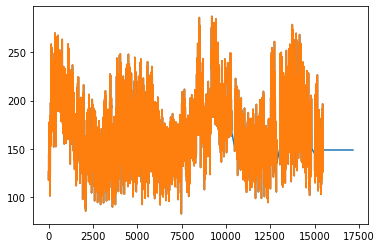

In [7]:

fig, ax = plt.subplots()
ax.plot(data2['value'].reset_index(drop=True).interpolate(method='linear'))
ax.plot(data2['value'].reset_index(drop=True))

plt.show()

## Machine Learning Preparation

In [8]:
#Pre processes the dataframe
def machine_processor(df_,last_day):
    df_ = df_.copy()
    df_ = df_.reset_index().set_index('date').drop(columns='variable').loc[idx[:last_day],:]
    
    df_ = (build_some_features(df_,
                     target_column='value',
                     num_periods_lagged=8, 
                     num_periods_diffed=8, 
                     weekday=True, 
                     month=True, 
                     hour=True#,
                     #rolling=[np.mean,np.min,np.max,np.std]
                    ).dropna())
    return df_

In [9]:
#dataprep1 = data1.copy().reset_index().set_index('date').drop(columns='variable').loc[idx[:data1_last_hour],:]

In [10]:
def build_some_features(df_, 
                        target_column='value', 
                        num_periods_lagged=1, 
                        num_periods_diffed=0, 
                        weekday=False, 
                        month=False, 
                        hour=True, 
                        rolling =[]): 
    """
    Builds some features by calculating differences between periods  
    """
    # make a copy 
    df_ = df_.copy()
        
    # for a few values, get the lags  
    for i in range(1, num_periods_lagged+1):
        # make a new feature, with the lags in the observed values column
        df_['lagged_%s' % str(i)] = df_[target_column].shift(i)
        
    # for a few values, get the diffs  
    for i in range(1, num_periods_diffed+1):
        # make a new feature, with the diffs in the observed values column
        df_['diff_%s' % str(i)] = df_[target_column].diff(i)
    
    for stat in rolling:
        df_['rolling_%s'%str(stat)] = df_[target_column].rolling('12h').aggregate(stat)
        
    if weekday == True:
        df_['sin_weekday'] = np.sin(2*np.pi*df_.index.weekday/7)
        df_['cos_weekday'] = np.sin(2*np.pi*df_.index.weekday/7)
        
    if month == True:
        df_['sin_month'] = np.sin(2*np.pi*df_.index.month/12)
        df_['cos_month'] = np.sin(2*np.pi*df_.index.month/12)
        
    if hour == True:
        df_['sin_hour'] = np.sin(2*np.pi*df_.index.hour/24)
        df_['cos_hour'] = np.sin(2*np.pi*df_.index.hour/24)        

    
    return df_

In [11]:
# data1ready = (build_some_features(dataprep1,
#                      target_column='value',
#                      num_periods_lagged=8, 
#                      num_periods_diffed=8, 
#                      weekday=True, 
#                      month=True, 
#                      hour=True#,
#                      #rolling=[np.mean,np.min,np.max,np.std]
#                     )
#  .dropna())

In [12]:
#creates the target shift
def target_shift(df_, target_columnn, shift_period=1):
    #returns the same dataframe with the column "target" as the input columns but shifted "shift_period" times
    df_ = df_.copy()
    df_['target'] = df_[target_columnn].shift(-shift_period)
    df_ = df_.dropna()
    return df_


def separate_last_day(df_):
    
    """
    takes a dataset which has the target and features built 
    and separates it into the last day
    """
    # take the last period 
    last_period = df_.iloc[-1]
    
    # the last period is now a series, so it's name will be the timestamp
    training_data = df_.loc[df_.index < last_period.name]

    return last_period, training_data


def separate_train_and_test_set(last_period_, training_data_, target='target'): 
    
    """ 
    separates training and test set (clue was in the name, really... )
    Ok, we were lazy and left the target hardcoded as 'target'. Shame on us. 
    """
    
    # anything that isn't a target is a feature 
    features = [feature for feature in training_data_.columns if feature != target]
    
    # adding a sneaky little dropna to avoid the missing data problem above 
    X_train = training_data_.dropna()[features]
    y_train = training_data_.dropna()[target]
    
    X_last_period = last_period_[features]
    
    return X_train, y_train, X_last_period



def predict_period_n(df_, model,period):

    df_ = df_.copy()
    
    df_ = target_shift(df_,'value',period)

    last_period, training_data = separate_last_day(df_)

    X_train, y_train, X_last_period = separate_train_and_test_set(last_period, 
                                                           training_data, 
                                                           target='target')
    model.fit(X_train, y_train)
    return model.predict(X_last_period.values.reshape(1, -1))


def predict_n_periods(df_, model, n_periods): 
    predictions = []

    for period_ahead in range(1, n_periods+1):
        pred = predict_period_n(df_, model, period_ahead)
        
        predictions.append(pred[0])
        
    return predictions 

## Whole Data

In [13]:
data1ReadyWhole = machine_processor(data1,data1_last_hour)
data2ReadyWhole = machine_processor(data2,data2_last_hour)
data3ReadyWhole = machine_processor(data3,data3_last_hour)

## Just to create output . Validation next

In [14]:
areasPredict = [data1ReadyWhole, data2ReadyWhole, data3ReadyWhole]
areasModels = [LinearRegression(),LinearRegression(), LinearRegression()]

predictions = pd.DataFrame()
for counter,areas in enumerate(areasPredict):
    
    predictions = predict_n_periods(areas, model = areasModels[counter], n_periods=24*7)
    predictions_time =pd.DataFrame(predictions).set_index(
        pd.date_range(start=data1_next_hour, periods = 7 * 24, freq='1h')
    )
    predictions_time.index.name = 'date'
    predictions_time.columns=["value"]
    
    predictions_time.to_csv('linear_model_data_{}.csv'.format(counter + 1))

In [15]:
predictions = predict_n_periods(data2ready, model = LinearRegression(), n_periods=24*7)

NameError: name 'data2ready' is not defined

In [ ]:
predictions_time =pd.DataFrame(predictions).set_index(
pd.date_range(start=data1_next_hour, periods = 7 * 24, freq='1h')
)
predictions_time.index.name = 'date'
predictions_time.columns=["value"]

In [ ]:
data3.reset_index(drop=True).plot()
pd.read_csv('linear_model_data_3.csv').reset_index(drop=True).plot()
plt.show()

In [267]:
data1ReadyWhole.index[-1]

Timestamp('2005-05-22 23:00:00')

## Cross Validation??

In [11]:
def predict_machine(df_, model, n_periods= 7 * 24):

    predictions = pd.DataFrame()
    last_date_dataframe = df_.index[-1]
    first_date_prediction = pd.to_datetime(last_date_dataframe) + dt.timedelta(hours=1)
    
    predictions = predict_n_periods(df_, model, n_periods)
    predictions_time =pd.DataFrame(predictions).set_index(
        pd.date_range(start=first_date_prediction, periods = n_periods, freq='1h')
    )
    predictions_time.index.name = 'date'
    predictions_time.columns=["value"]
    return predictions_time
    

## Train Test Split

In [12]:
data1ReadyTest = data1ReadyWhole.loc[idx[data1_test_hour:]]
data2ReadyTest = data2ReadyWhole.loc[idx[data2_test_hour:]]
data3ReadyTest = data3ReadyWhole.loc[idx[data3_test_hour:]]

data1ReadyTrain = data1ReadyWhole.loc[idx[:data1_train_hour]]
data2ReadyTrain = data2ReadyWhole.loc[idx[:data2_train_hour]]
data3ReadyTrain = data3ReadyWhole.loc[idx[:data3_train_hour]]

In [13]:
loss=['ls', 'lad', 'huber', 'quantile']
learning_rate=[0.1, 1]
n_estimators=[100]
subsample=[1.0]
criterion=['friedman_mse']
min_samples_split=[2]
min_samples_leaf=[1]
random_state=[42]
max_features=[None]
alpha=[0.9]



params_combinations = list(itertools.product(loss,
                                            learning_rate,
                                            n_estimators,
                                            subsample,
                                            criterion,
                                            min_samples_split,
                                            min_samples_leaf,
                                            random_state,
                                            max_features,
                                            alpha))
inputs = [[x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9]] for x in params_combinations]

In [20]:

#GradientBoostingRegressor cross validation

mae_scores = {}
param_index = {}

for counter, inp in enumerate(inputs):
    print('counter =', counter)
    loss=inp[0]
    learning_rate=inp[1]
    n_estimators=inp[2]
    subsample=inp[3]
    criterion=inp[4]
    min_samples_split=inp[5]
    min_samples_leaf=inp[6]
    random_state=inp[7]
    max_features=inp[8]
    alpha=inp[9]
    
    model = GradientBoostingRegressor(loss=loss,
                                      learning_rate=learning_rate,
                                      n_estimators=n_estimators,
                                      subsample=subsample,
                                      criterion=criterion,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf,
                                      random_state=random_state,
                                      max_features=max_features,
                                      alpha=alpha)
    
    
    predictions = predict_machine(data1ReadyTrain ,model = model,n_periods = 168)
    mae_model = mean_absolute_error(data1ReadyTest['value'],predictions)
    mae_scores[i] = mae_model
    params_index[i] = inp

counter = 0


NameError: name 'model_mae' is not defined

In [19]:
mean_absolute_error(data1ReadyTest['value'],predictions)

2.7320819703413033

In [ ]:
temp = pd.DataFrame(params_index).T
#temp.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'S']
temp['mae'] = pd.Series(mae_scores)

temp.sort_values('mae')

## Gradient Results

In [ ]:
   areasPredict = [data1ReadyWhole, data2ReadyWhole, data3ReadyWhole]
areasModels = [GradientBoostingRegressor(random_state=42),GradientBoostingRegressor(random_state=42), GradientBoostingRegressor(random_state=42)]

predictions = pd.DataFrame()
for counter,areas in enumerate(areasPredict):
    
    predictions = predict_n_periods(areas, model = areasModels[counter], n_periods=24*7)
    predictions_time =pd.DataFrame(predictions).set_index(
        pd.date_range(start=data1_next_hour, periods = 7 * 24, freq='1h')
    )
    predictions_time.index.name = 'date'
    predictions_time.columns=["value"]
    
    predictions_time.to_csv('gradientboosting_model_data_{}.csv'.format(counter + 1))
    

## SVM Results

In [24]:
model_SVM=svm.SVR(kernel='rbf',
        degree=3,
        gamma='auto_deprecated',
        coef0=0.0,
        tol=0.001,
        C=1.0,
        epsilon=0.1,
        shrinking=True,
        cache_size=200,
        verbose=False,
        max_iter=-1)

areasPredict = [data1ReadyWhole, data2ReadyWhole, data3ReadyWhole]
areasModels = [model_SVM, model_SVM, model_SVM]



predictions = pd.DataFrame()
for counter,areas in enumerate(areasPredict):
    
    predictions = predict_n_periods(areas, model = areasModels[counter], n_periods=24*7)
    predictions_time =pd.DataFrame(predictions).set_index(
        pd.date_range(start=data1_next_hour, periods = 7 * 24, freq='1h')
    )
    predictions_time.index.name = 'date'
    predictions_time.columns=["value"]
    
    predictions_time.to_csv('SVM_model_data_{}.csv'.format(counter + 1))

KeyboardInterrupt: 

In [29]:
#creating gradient output result
dataread1 = pd.read_csv('gradientboosting_model_data_1.csv')
dataread1['date'] = pd.to_datetime(dataread1['date'])
dataread1 = dataread1.set_index(['date'])
dataread1 = dataread1.sort_index()

In [30]:
dataread2 = pd.read_csv('gradientboosting_model_data_2.csv')
dataread2['date'] = pd.to_datetime(dataread2['date'])
dataread2 = dataread2.set_index(['date'])
dataread2 = dataread2.sort_index()

In [31]:
dataread3 = pd.read_csv('gradientboosting_model_data_3.csv')
dataread3['date'] = pd.to_datetime(dataread3['date'])
dataread3 = dataread3.set_index(['date'])
dataread3 = dataread3.sort_index()

In [34]:
def generate_submission_file(predictions_area_1, predictions_area_2, predicitons_area_3):
    test_1 = pd.DataFrame(predictions_area_1,index=pd.date_range(start='23/05/2005', end='30/05/2005', freq='h')[:-1])
    test_2 = pd.DataFrame(predictions_area_2,index=pd.date_range(start='2005-10-07', end='2005-10-14', freq='h')[:-1])
    test_3 = pd.DataFrame(predicitons_area_3,index=pd.date_range(start='2005-12-16', end='2005-12-23', freq='h')[:-1])
    test = pd.concat([test_1,test_2,test_3], axis=1)
    test.columns = ['area_1','area_2','area_3']
    test.index.name = 'date'
    test = test.reset_index().melt(id_vars='date',value_vars=['area_1','area_2','area_3']).set_index('date')
    test = test.dropna()
    test = test.drop('variable',axis=1)
    test.to_csv('submission.csv')
    return test


generate_submission_file(dataread1.values,dataread2.values,dataread3.values)

,value
date,
2005-05-23 00:00:00,13.443584
2005-05-23 01:00:00,14.103060
2005-05-23 02:00:00,15.249488
2005-05-23 03:00:00,14.349435
2005-05-23 04:00:00,12.551493
2005-05-23 05:00:00,12.052554
2005-05-23 06:00:00,12.076208
2005-05-23 07:00:00,12.496120
2005-05-23 08:00:00,13.675471
